# Automated Brain Tumor Detection Using Deep Learning Techniques (CNN)

Introduction:

Brain tumors represent a major global health concern, affecting both children and adults. Early and accurate diagnosis plays a crucial role in treatment planning and improving patient outcomes. Magnetic Resonance Imaging (MRI) is the primary imaging modality for detecting brain tumors, producing large volumes of image data that require careful analysis by radiologists. However, manual examination is prone to errors due to the complexity and variability of brain tumors.

This project proposes the development of an automated system for brain tumor classification using Convolutional Neural Networks (CNNs).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

plt.style.use('seaborn-v0_8')


from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import random
from PIL import Image
import glob
import seaborn as sns
from tqdm.notebook import tqdm
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve,auc, accuracy_score, confusion_matrix, classification_report

import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Load Visualization

In [ ]:
train_path = "/content/drive/MyDrive/Brain-Tumor-Classification-DataSet-master/Testing"
test_path = "/content/drive/MyDrive/Brain-Tumor-Classification-DataSet-master/Training"

classes = ['no_tumor','pituitary_tumor', 'meningioma_tumor','glioma_tumor']
#classes.index('no_tumor')

X_train = []
Y_train = []
# Function to load images and assign a class
def load_data(directory):
    for class_name in tqdm(os.listdir(directory),desc=directory):
        class_path = os.path.join(directory, class_name)
        class_label = class_name
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            X_train.append(img)
            Y_train.append(classes.index(class_name))
    return X_train,Y_train

X_train , Y_train = load_data(train_path)
X_train , Y_train = load_data(test_path)

/content/drive/MyDrive/Brain-Tumor-Classification-DataSet-master/Testing:   0%|          | 0/4 [00:00<?, ?it/s…

/content/drive/MyDrive/Brain-Tumor-Classification-DataSet-master/Training:   0%|          | 0/4 [00:00<?, ?it/…

# Data Visualization

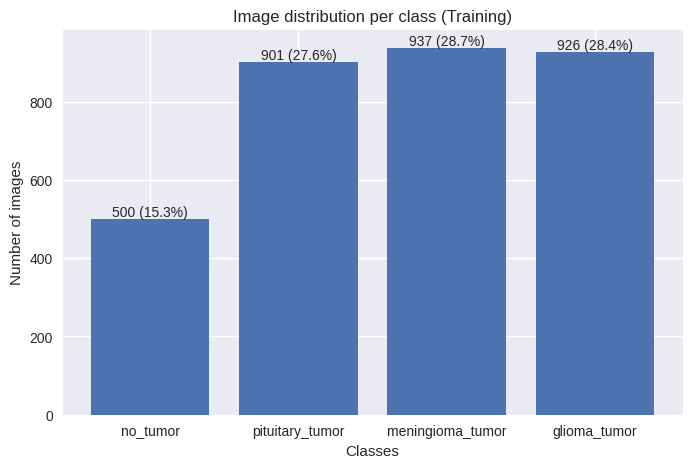

In [ ]:
# Function to count the number of images per class
def count_images_per_class(data, classes):
    count_per_class = {class_name: 0 for class_name in classes}
    for class_idx in data:
        class_name = classes[class_idx]
        count_per_class[class_name] += 1
    return count_per_class

# Count the number of images per class for the training and test sets
train_count_per_class = count_images_per_class(Y_train, classes)

plt.figure(figsize=(8, 5))
# Training data
train_bars = plt.bar(train_count_per_class.keys(), train_count_per_class.values(), color='#4C72B0')
plt.title('Image distribution per class (Training)')
plt.xlabel('Classes')
plt.ylabel('Number of images')

# Add percentages
for bar in train_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height} ({height / np.sum(list(train_count_per_class.values())) * 100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

plt.show()

# Examples of images for each class

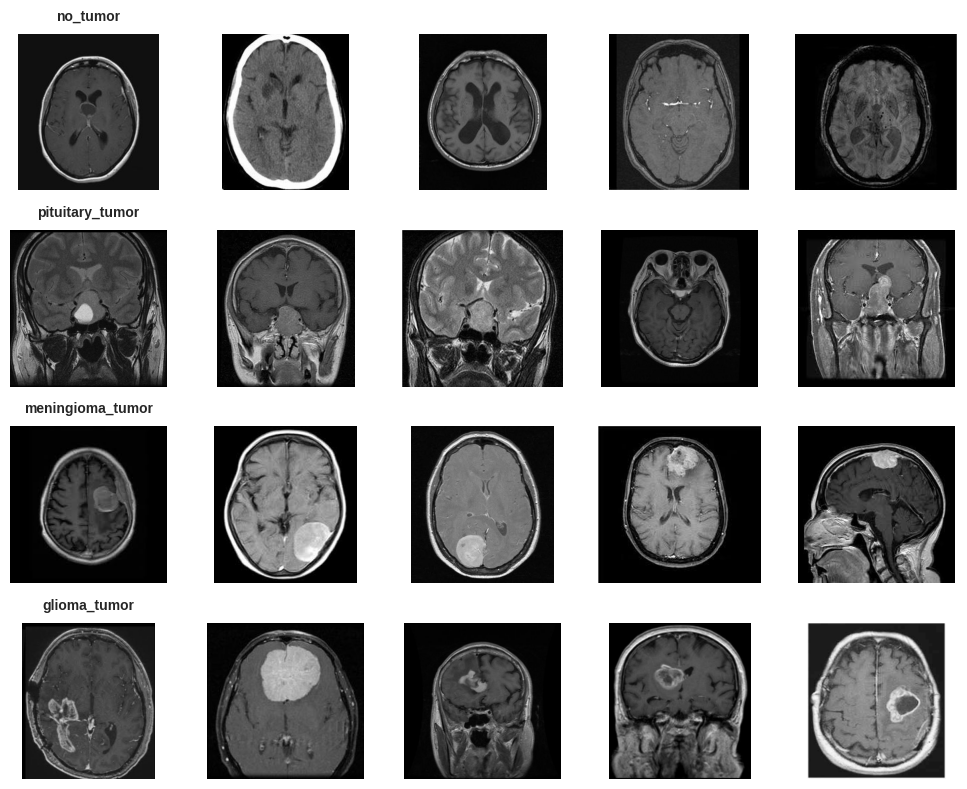

In [ ]:
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

show_examples(X_train, Y_train, classes)

# Most common image size


In [ ]:
# Most frequent image sizes:
train_data_shapes = []
for img in X_train:
    train_data_shapes.append(img.shape)

# Count occurrences for each size
shape_counts = {}
for shape in train_data_shapes:
    if shape not in shape_counts:
        shape_counts[shape] = 0
    shape_counts[shape] += 1

# Sort the shapes by count
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)

# Display the most frequent image sizes
print("Most frequent train image shapes:")
for shape, count in sorted_shapes[:3]:
    print(f"- {shape}: {count}")


Most frequent train image shapes:
- (512, 512, 3): 2341
- (236, 236, 3): 79
- (225, 225, 3): 43


Most images have a high resolution of 512×512 pixels. This high resolution can lead to longer processing times and increased memory usage. Therefore, to optimize model performance while maintaining adequate image quality, a lower resolution of 225×225 pixels is preferred.

In [ ]:
shape = (225, 225, 3)

# Data preparation


In [ ]:
# Function to crop an image
def crop_image(image):
    # Convert the image to grayscale
    if len(image.shape) == 3:  # Check if the image is in BGR format
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # Image is already in grayscale
        gray = image.copy()

    # Threshold the image
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Find contours in the image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Crop the image to the largest contour
    cropped_image = image[
        cv2.boundingRect(largest_contour)[1] : cv2.boundingRect(largest_contour)[1] + cv2.boundingRect(largest_contour)[3],
        cv2.boundingRect(largest_contour)[0] : cv2.boundingRect(largest_contour)[0] + cv2.boundingRect(largest_contour)[2]
    ]

    return cropped_image


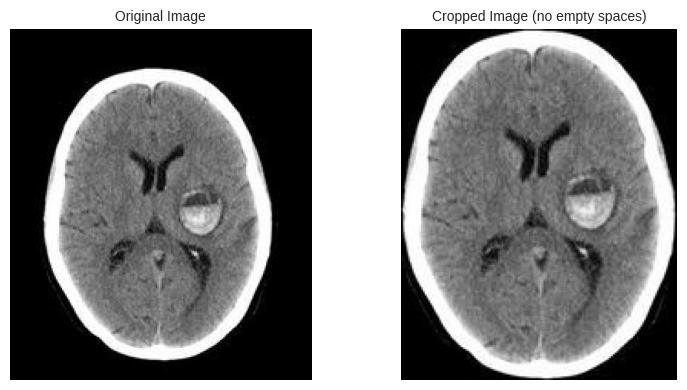

In [ ]:
image_path = "/content/drive/MyDrive/Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor/image(56).jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Load and crop the image
cropped_image = crop_image(img)

# Display the original and cropped images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Original Image", fontsize=10)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_image, cmap='gray')
plt.title("Cropped Image (no empty spaces)", fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Crop, normalize, and resize all images
def preprocess_data(train_data):
    processed_data = []
    for img in tqdm(train_data):

        # Apply cropping
        cropped_img = crop_image(img)

        # Resize the image
        resized_img = cv2.resize(cropped_img, (shape[1], shape[0]))

        # Normalize the image
        # normalized_img = resized_img / 255.0
        normalized_img = cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # Append the preprocessed image to processed data
        processed_data.append(normalized_img)

    return processed_data

# Preprocess training and test data
X_train = preprocess_data(X_train)

X_train = np.array(X_train)


  0%|          | 0/3264 [00:00<?, ?it/s]

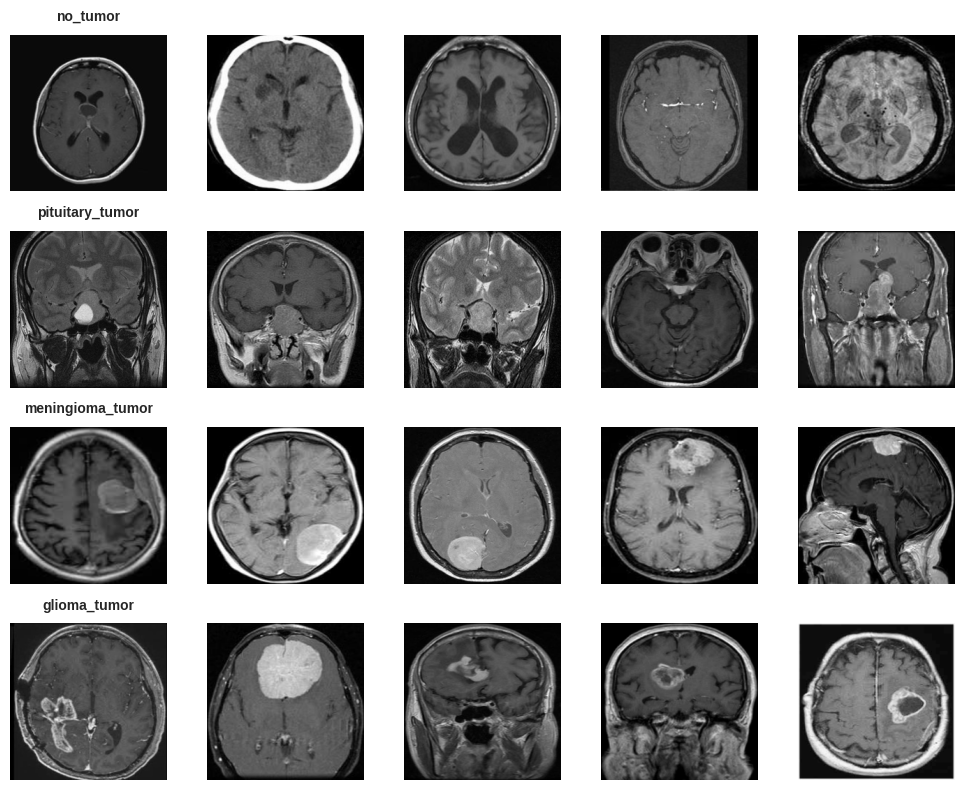

In [ ]:
# Function to display example images for each class after preprocessing
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
            img = X_data[class_indices[j]]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Display example images for each class after preprocessing
show_examples(X_train, Y_train, classes)

In [ ]:
X_train, Y_train = shuffle(X_train,Y_train, random_state=64)
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.3,random_state=64)
X_test,X_val,Y_test,Y_val = train_test_split(X_test,Y_test, test_size=2/3,random_state=64)

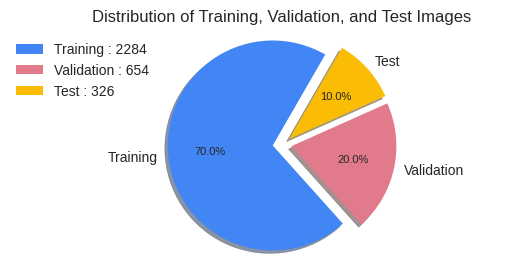

In [ ]:
sizes = [len(Y_train), len(Y_val), len(Y_test)]
labels = ['Training', 'Validation', 'Test']
colors = ['#4285f4', '#E17A8A', '#fbbc05']

plt.figure(figsize=(6,3))
plt.rcParams.update({'font.size': 8})
patches, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%.1f%%',
    explode=(0.1, 0.08, 0.08),
    shadow=True,
    startangle=60
)
plt.title("Distribution of Training, Validation, and Test Images")
plt.legend(
    patches,
    [f"{label} : {size}" for label, size in zip(labels, sizes)],
    loc="upper left",
    bbox_to_anchor=(-0.1, 1)  # Décale la légende plus à gauche
)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



In [ ]:
Y_train =  np.array(tensorflow.keras.utils.to_categorical(Y_train))
Y_val =  np.array(tensorflow.keras.utils.to_categorical(Y_val))
Y_test =  np.array(tensorflow.keras.utils.to_categorical(Y_test))

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(
    x=np.array(X_train),
    y=np.array(Y_train)
)

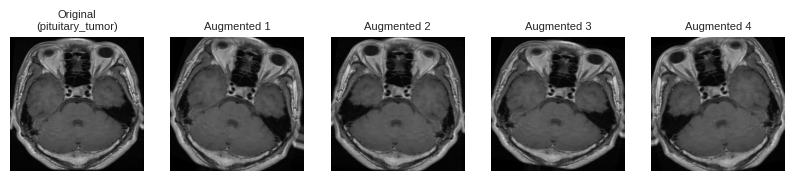

In [ ]:
random_index = np.random.randint(len(X_train))
image = X_train[random_index]
class_label_encoded = Y_train[random_index]
class_label = classes[np.argmax(class_label_encoded)]

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title('Original\n({})'.format(class_label), fontsize=8)
plt.axis('off')

# Generate and display augmented versions of the image
for i in range(4):
    augmented_image = train_datagen.random_transform(image)
    plt.subplot(1, 5, i + 2)
    plt.imshow(augmented_image)
    plt.title('Augmented {}'.format(i + 1), fontsize=8)
    plt.axis('off')

plt.show()


# Modelisation

In [ ]:
CNN_model = Sequential()
CNN_model.add(Conv2D(16, (3,3), activation='relu', input_shape=shape))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(32, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(64, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(512, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Flatten())
CNN_model.add(Dense(512, activation='relu'))
CNN_model.add(Dropout(0.5))

CNN_model.add(Dense(len(classes), activation='softmax'))


CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
CNN_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 223, 223, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,243,940 (27.63 MB)

 Trainable params: 7,243,940 (27.63 MB)

 Non-trainable params: 0 (0.00 B)

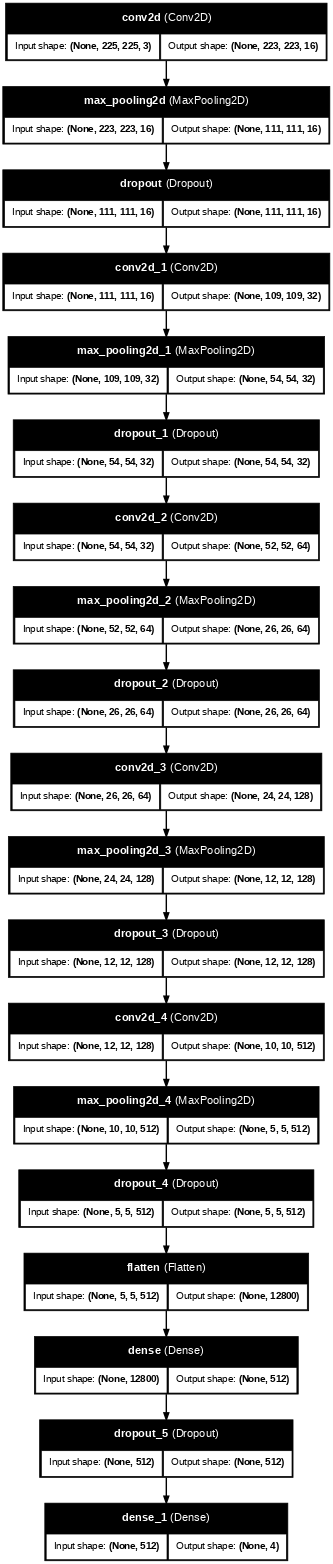

In [ ]:
tensorflow.keras.utils.plot_model(CNN_model,show_shapes=True, show_layer_names=True, dpi=50)


In [ ]:
# Define batch size
batch_size = 64

# Image shape: height, width, RGB
image_shape = shape

# Number of epochs
epochs = 80

print(f'Batch size: {batch_size}')
print(f'Image shape: {image_shape}')
print(f'Number of epochs: {epochs}')

Batch size: 64
Image shape: (225, 225, 3)
Number of epochs: 80


In [ ]:
# Add ReduceLROnPlateau, EarlyStopping, and ModelCheckpoint as callbacks during training
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # metric to monitor
    factor=0.1,              # factor to reduce learning rate
    patience=10,             # number of epochs with no improvement before reducing LR
    min_delta=0.0001,        # minimum change to qualify as improvement
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',      # metric to monitor
    patience=15,             # number of epochs with no improvement before stopping
    restore_best_weights=True,  # restore the best model weights
    verbose=1
)  # Stops training early if validation performance doesn't improve over a number of epochs

checkpoint = ModelCheckpoint(
    filepath='best_CNNModel.keras',  # file path to save the model
    monitor='val_accuracy',          # metric to monitor
    save_best_only=True,             # save only the best model
    verbose=1
)  # Saves the best model based on validation performance


In [ ]:
import time
# Train the model
start_time = time.time()
CNN_history = CNN_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)
end_time = time.time()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2893 - loss: 1.4262 - precision: 0.1849 - recall: 0.0101
Epoch 1: val_accuracy improved from -inf to 0.29664, saving model to best_CNNModel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.2891 - loss: 1.4255 - precision: 0.1849 - recall: 0.0100 - val_accuracy: 0.2966 - val_loss: 1.3742 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3124 - loss: 1.3225 - precision: 0.2133 - recall: 0.0038
Epoch 2: val_accuracy improved from 0.29664 to 0.29817, saving model to best_CNNModel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.3129 - loss: 1.3221 - precision: 0.2186 - recall: 0.0041 - val_accuracy: 0.2982 - val_loss: 1.4710 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3922 - loss: 1.2422 - precision: 0.5859 - recall: 0.0458

In [ ]:
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")
hours = int(runtime / 3600)
minutes = int((runtime % 3600) / 60)
seconds = int(runtime % 60)

print("Total runtime:", hours, "hours,", minutes, "minutes,", seconds, "seconds")


Runtime: 8630.859731674194 seconds
Total runtime: 2 hours, 23 minutes, 50 seconds


In [ ]:
CNN_history.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

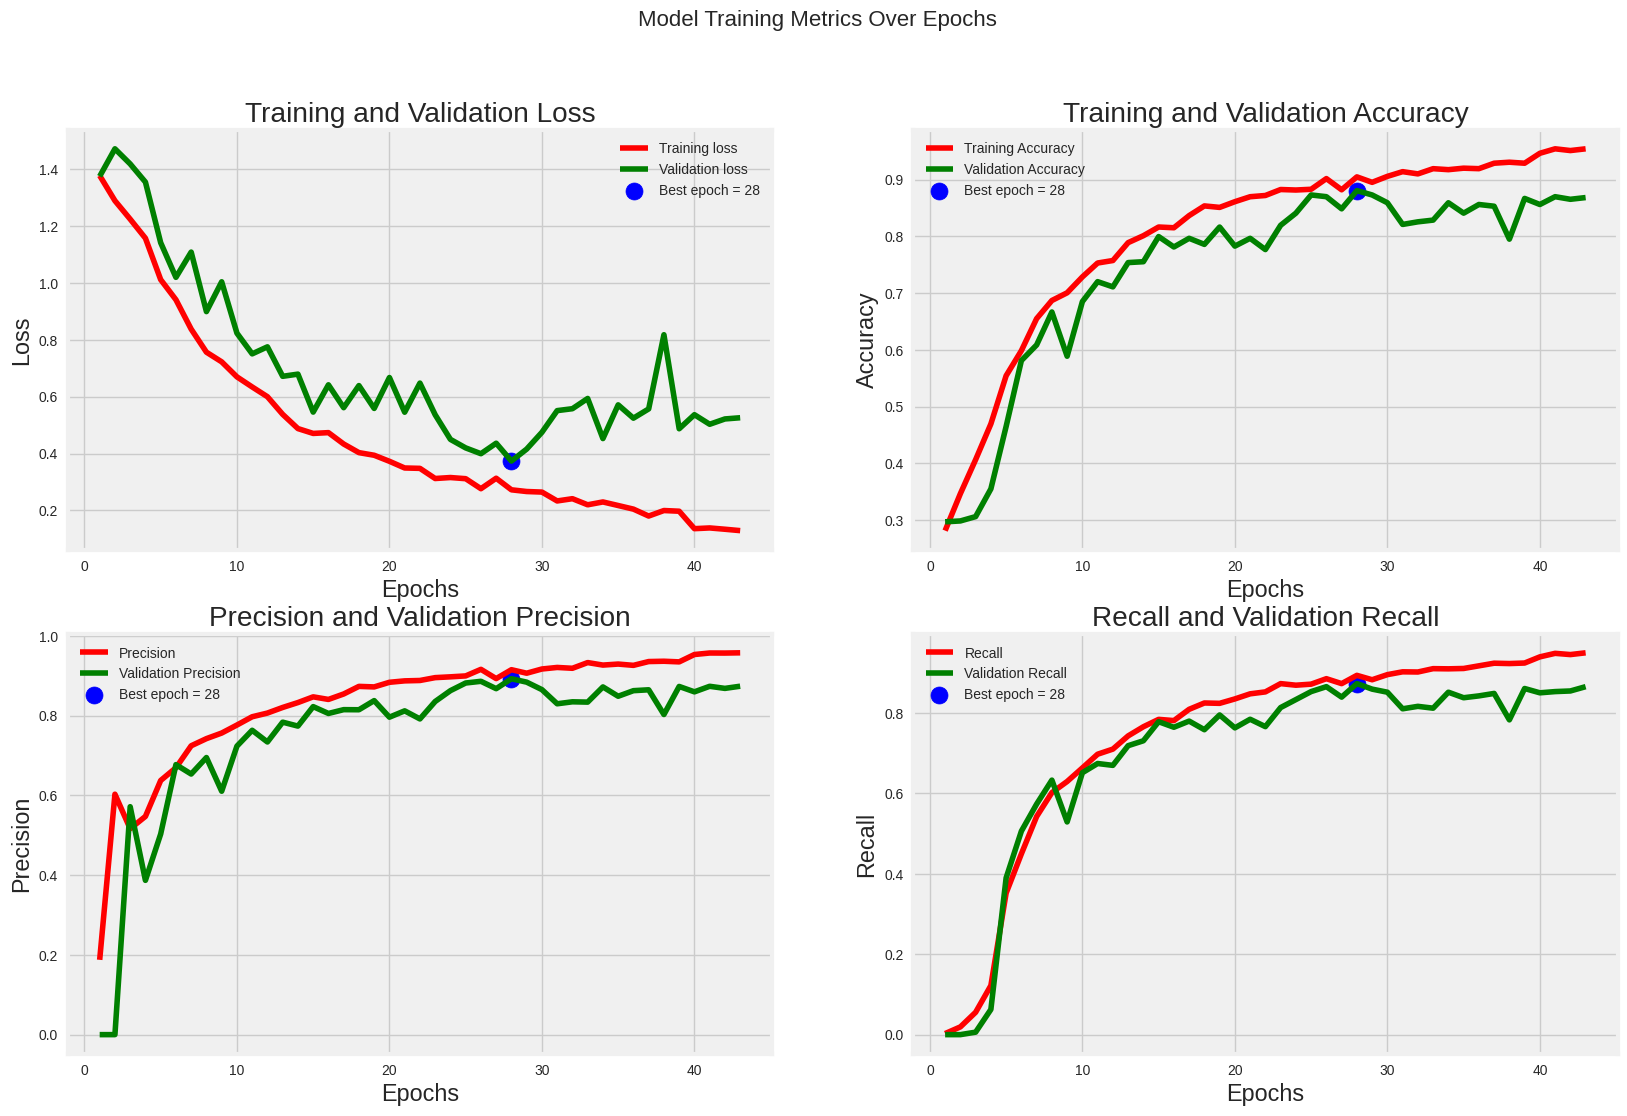

In [ ]:
tr_acc = CNN_history.history['accuracy']
tr_loss = CNN_history.history['loss']
tr_per = CNN_history.history['precision']
tr_recall = CNN_history.history['recall']
val_acc = CNN_history.history['val_accuracy']
val_loss = CNN_history.history['val_loss']
val_per = CNN_history.history['val_precision']
val_recall = CNN_history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
train_result = CNN_model.evaluate(X_train,Y_train)
print("Train Loss: {:.2f}%".format(train_result[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result[1] * 100))
print("Train Precision: {:.2f}%".format(train_result[2] * 100))
print("Train Recall: {:.2f}%".format(train_result[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 592ms/step - accuracy: 0.9360 - loss: 0.1734 - precision: 0.9422 - recall: 0.9278
Train Loss: 16.10%
Train Accuracy: 94.18%
Train Precision: 94.64%
Train Recall: 93.48%


In [ ]:
test_results = CNN_model.evaluate(X_test,Y_test)

print("Test Loss: {:.2f}%".format(test_results[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Precision: {:.2f}%".format(test_results[2] * 100))
print("Test Recall: {:.2f}%".format(test_results[3] * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 476ms/step - accuracy: 0.9193 - loss: 0.2670 - precision: 0.9179 - recall: 0.9023
Test Loss: 27.08%
Test Accuracy: 91.72%
Test Precision: 91.64%
Test Recall: 90.80%


In [ ]:
predictions = CNN_model.predict(X_test)
y_true_test = np.argmax(Y_test, axis=1)
y_pred_test = np.argmax(predictions, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 629ms/step


In [ ]:
accuracy = accuracy_score(y_true_test, y_pred_test)
print("Accuracy:{:.2f}%".format(accuracy * 100))

Accuracy:91.72%


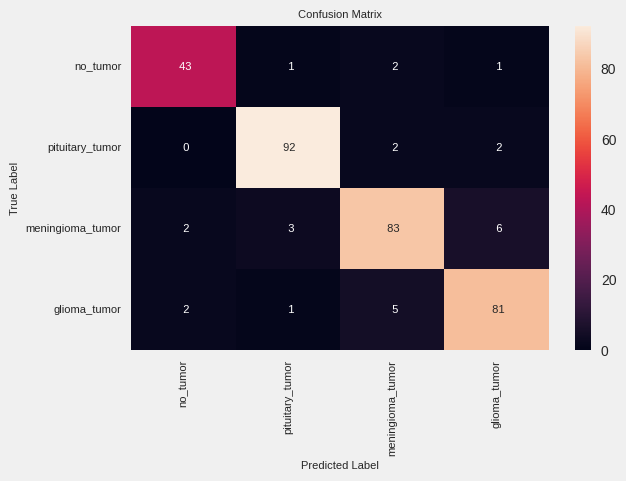

In [ ]:
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='3g',
                      xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})

plt.title('Confusion Matrix',fontsize=8)
plt.xlabel('Predicted Label',fontsize=8)
plt.ylabel('True Label',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
class_report = classification_report(y_true_test, y_pred_test, target_names=classes)
print("Classification Report:")
print(class_report)

Classification Report:
                  precision    recall  f1-score   support

        no_tumor       0.91      0.91      0.91        47
 pituitary_tumor       0.95      0.96      0.95        96
meningioma_tumor       0.90      0.88      0.89        94
    glioma_tumor       0.90      0.91      0.91        89

        accuracy                           0.92       326
       macro avg       0.92      0.92      0.92       326
    weighted avg       0.92      0.92      0.92       326



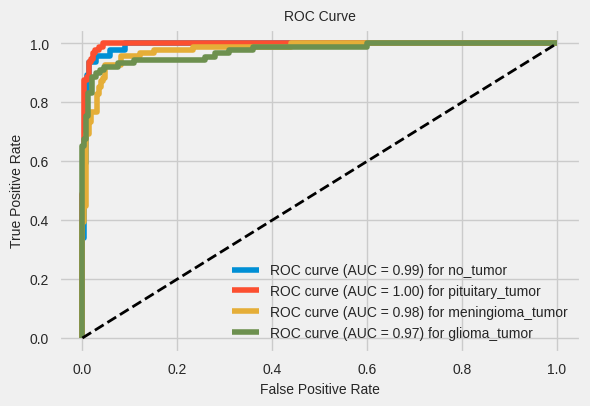

In [ ]:
y_pred_prob = predictions
y_true_test_OneHot = np.array(tensorflow.keras.utils.to_categorical(y_true_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(6,4))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true_test_OneHot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}) for {classes[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curve', fontsize=10)
plt.legend(loc='lower right', fontsize=10)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


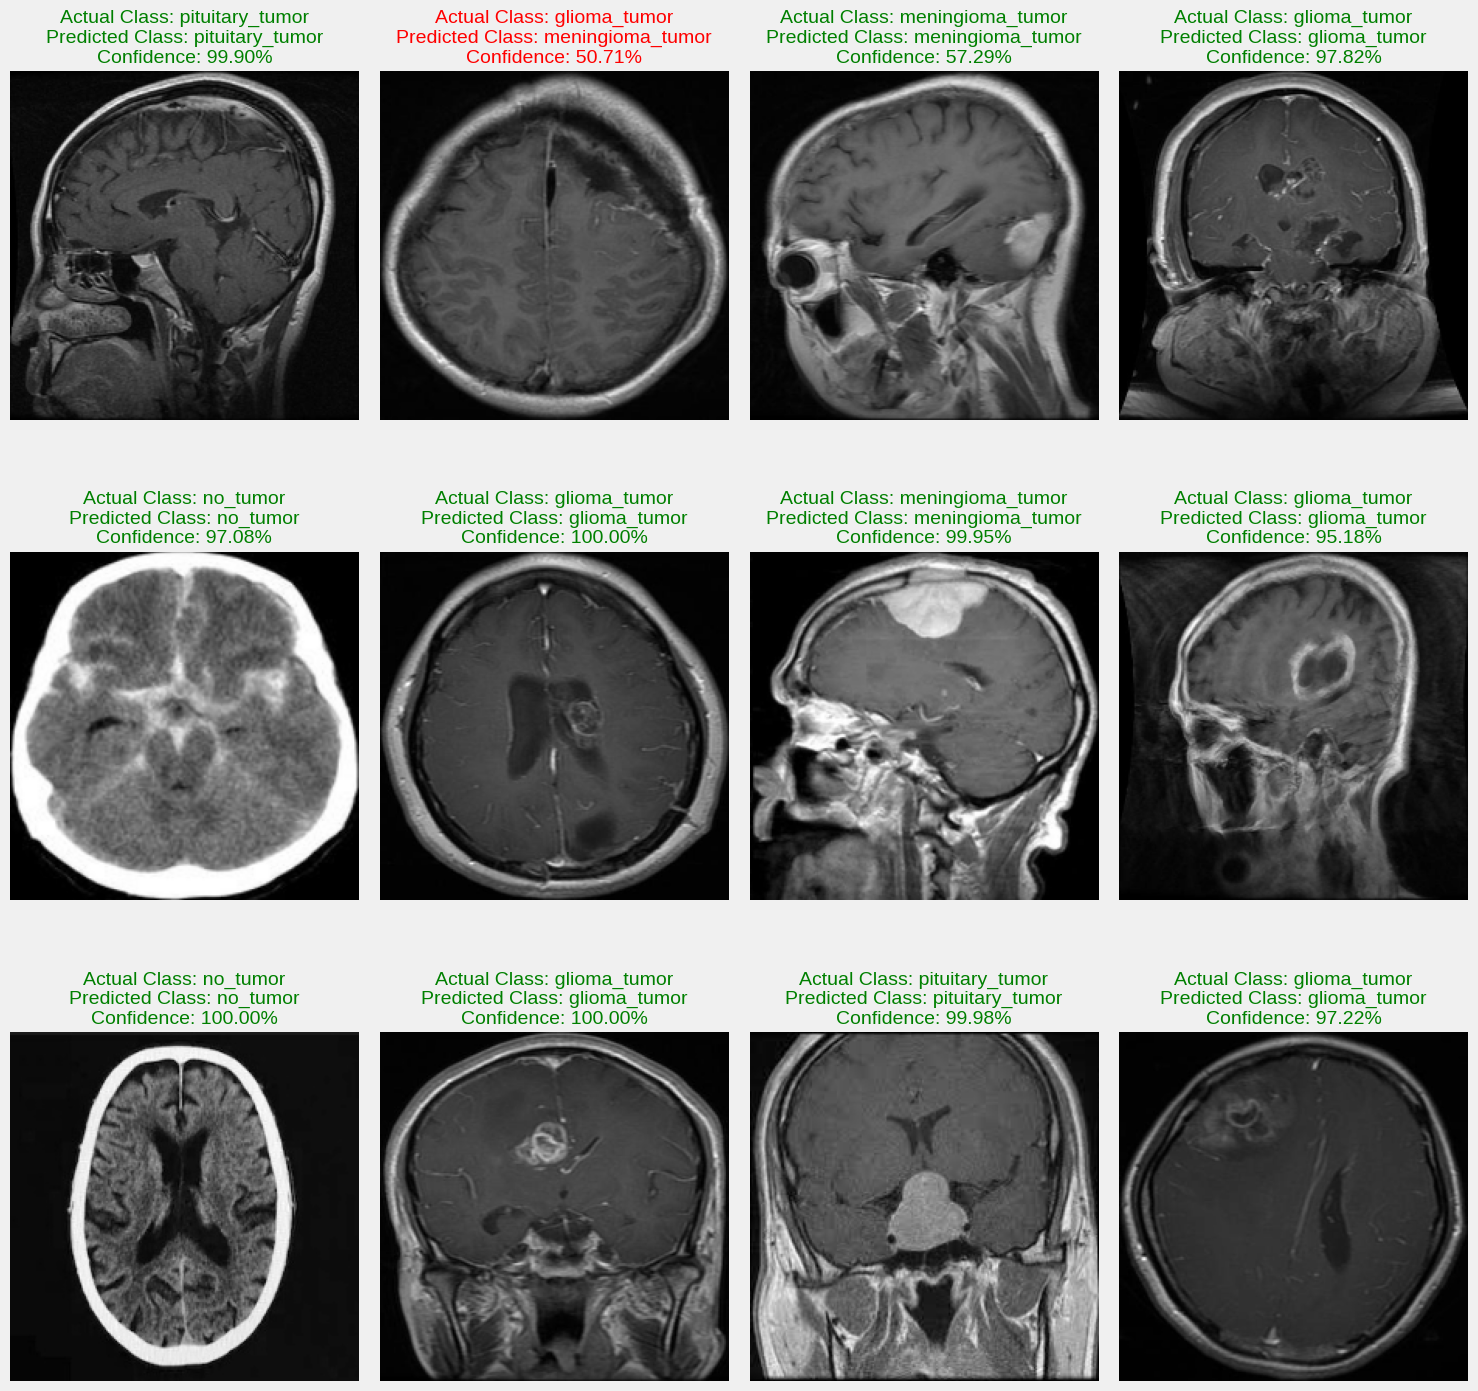

In [ ]:

indices = np.random.choice(len(Y_test), size=12, replace=False)

images = X_test
Y_test = np.argmax(Y_test, axis=1)
labels = Y_test

plt.figure(figsize=(15, 15))

for i, idx in enumerate(indices):
    image = images[idx]
    true_label = classes[labels[idx]]


    prediction = CNN_model.predict(np.expand_dims(image, axis=0))
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction) * 100


    color = 'green' if true_label == predicted_class else 'red'


    plt.subplot(3, 4, i+1)
    plt.imshow(image)
    plt.title(f"Actual Class: {true_label}\nPredicted Class: {predicted_class}\nConfidence: {confidence:.2f}%", color=color, fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
y_test :  glioma_tumor
y_pred :  glioma_tumor


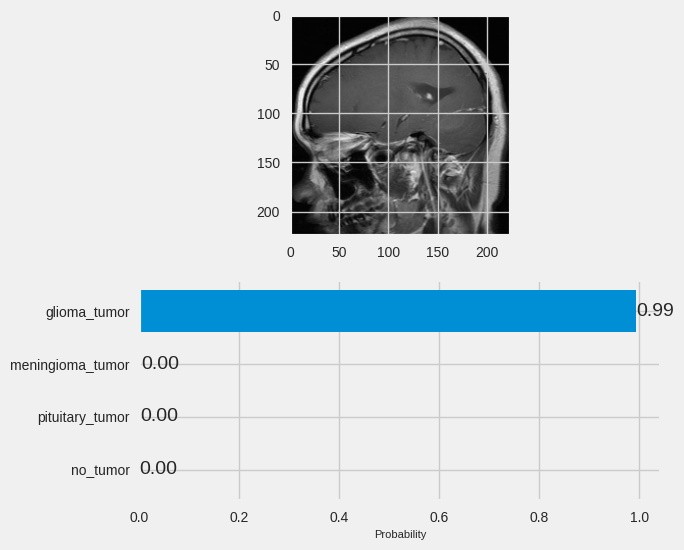

In [ ]:
plt.figure(figsize=(6, 6))
resized_img = cv2.resize(X_test[1], (shape[1], shape[0]))
img = np.asarray(resized_img)
img = np.expand_dims(img, axis=0)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
predictions = CNN_model.predict(img)
print('y_test : ',classes[Y_test[1]])
y_pred = np.argmax(predictions, axis=1)
print('y_pred : ',classes[y_pred[0]])
probs = list(predictions[0])
labels = classes
plt.subplot(2, 1, 1)
plt.imshow(resized_img)
plt.subplot(2, 1, 2)
bars = plt.barh(labels, probs)
plt.xlabel('Probability', fontsize=8)
ax = plt.gca()
ax.bar_label(bars, fmt = '%.2f')
plt.yticks(fontsize=10)
plt.show()

In [ ]:
CNN_model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
CNN_model = load_model('model.h5')